## Part 2B - Benchmark: ARPU vs ratio metric + linearization
This notebook compares three approaches on the same user-level aggregates:

ARPU (mean revenue per user)
Ratio metric: revenue per session (group-level ratio)
Linearization for ratio metrics (user-level transformation + t-test)
We evaluate:

effect estimates
confidence intervals
p-values
empirical power / type I error via repeated simulations

In [4]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

repo_root = Path('..').resolve()
src_path = (repo_root / 'src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

#from tecore.simulate import SyntheticB2CConfig, generate_user_level_data, make_default_scenarios

ALPHA = 0.05
RNG = np.random.default_rng(123)

## 1) Load synthetic scenarios (or regenerate)
If you already ran notebook 04, we load CSV files. If not, we regenerate them on the fly.

In [5]:
data_dir = repo_root / 'data' / 'synthetic'
scenario_files = {
    'scenario_monetization': data_dir / 'scenario_monetization.csv',
    'scenario_activity': data_dir / 'scenario_activity.csv',
    'scenario_mixed': data_dir / 'scenario_mixed.csv',
}

frames = {}
all_exist = all(p.exists() for p in scenario_files.values())

if all_exist:
    for name, p in scenario_files.items():
        frames[name] = pd.read_csv(p)
else:
    scenarios = make_default_scenarios(SyntheticB2CConfig(n_users=80_000, seed=42))
    for name, cfg in scenarios.items():
        frames[name] = generate_user_level_data(cfg)

list(frames.keys()), all_exist

(['scenario_monetization', 'scenario_activity', 'scenario_mixed'], False)

2) Helper functions
We implement three tests:

ARPU: two-sample t-test on revenue per user
Ratio: group-level ratio difference + bootstrap CI/p-value
Linearization: user-level z = revenue - R0 * sessions and t-test on z
Notes:

Linearization uses R0 computed on the control group.
For reporting, we convert linearized mean difference into ratio units.

In [6]:
def split_groups(df: pd.DataFrame):
    c = df[df['group'] == 'control'].copy()
    t = df[df['group'] == 'test'].copy()
    return c, t


def arpu_test(df: pd.DataFrame, alpha: float = ALPHA):
    c, t = split_groups(df)
    y_c, y_t = c['revenue'].to_numpy(), t['revenue'].to_numpy()

    # Welch t-test (robust to unequal variances)
    stat, pval = stats.ttest_ind(y_t, y_c, equal_var=False)

    eff = float(y_t.mean() - y_c.mean())
    se = float(np.sqrt(y_t.var(ddof=1)/len(y_t) + y_c.var(ddof=1)/len(y_c)))
    z = stats.norm.ppf(1 - alpha/2)
    ci = (eff - z*se, eff + z*se)

    return {
        'metric': 'ARPU',
        'effect': eff,
        'ci_low': ci[0],
        'ci_high': ci[1],
        'p_value': float(pval),
    }


def ratio_point(df: pd.DataFrame) -> float:
    return float(df['revenue'].sum() / df['sessions'].sum())


def ratio_bootstrap_test(df: pd.DataFrame, n_boot: int = 2000, alpha: float = ALPHA, seed: int = 0):
    c, t = split_groups(df)

    r_c = ratio_point(c)
    r_t = ratio_point(t)
    eff = r_t - r_c

    rng = np.random.default_rng(seed)
    c_idx = np.arange(len(c))
    t_idx = np.arange(len(t))

    boot = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        bc = c.iloc[rng.choice(c_idx, size=len(c), replace=True)]
        bt = t.iloc[rng.choice(t_idx, size=len(t), replace=True)]
        boot[i] = ratio_point(bt) - ratio_point(bc)

    lo = float(np.quantile(boot, alpha/2))
    hi = float(np.quantile(boot, 1 - alpha/2))

    # Two-sided p-value by bootstrap sign test around 0
    pval = float(2 * min((boot <= 0).mean(), (boot >= 0).mean()))

    return {
        'metric': 'Ratio bootstrap',
        'effect': float(eff),
        'ci_low': lo,
        'ci_high': hi,
        'p_value': pval,
    }


def linearization_test(df: pd.DataFrame, alpha: float = ALPHA):
    c, t = split_groups(df)

    # Baseline ratio from control
    R0 = ratio_point(c)

    z_c = c['revenue'].to_numpy() - R0 * c['sessions'].to_numpy()
    z_t = t['revenue'].to_numpy() - R0 * t['sessions'].to_numpy()

    stat, pval = stats.ttest_ind(z_t, z_c, equal_var=False)

    # Convert mean difference in z to ratio units
    mean_sessions_c = float(c['sessions'].mean())
    dz = float(z_t.mean() - z_c.mean())
    eff = dz / mean_sessions_c

    # CI from normal approximation on dz
    se_dz = float(np.sqrt(z_t.var(ddof=1)/len(z_t) + z_c.var(ddof=1)/len(z_c)))
    zcrit = stats.norm.ppf(1 - alpha/2)
    ci = ((dz - zcrit*se_dz)/mean_sessions_c, (dz + zcrit*se_dz)/mean_sessions_c)

    return {
        'metric': 'Ratio linearization',
        'effect': eff,
        'ci_low': float(ci[0]),
        'ci_high': float(ci[1]),
        'p_value': float(pval),
    }

## 3) One-run comparison for each scenario

In [7]:
def run_all_methods(df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
    rows = []
    rows.append(arpu_test(df))
    rows.append(ratio_bootstrap_test(df, n_boot=1200, seed=seed))
    rows.append(linearization_test(df))
    return pd.DataFrame(rows)

for name, df in frames.items():
    print('\n', '='*80)
    print(name)
    display(run_all_methods(df, seed=123))


scenario_monetization

scenario_activity

scenario_mixed


,metric,effect,ci_low,ci_high,p_value
0,ARPU,-0.003810,-0.302092,0.294472,0.980026
1,Ratio bootstrap,0.006606,-0.081396,0.088903,0.856667
2,Ratio linearization,0.006574,-0.081912,0.095060,0.884227


,metric,effect,ci_low,ci_high,p_value
0,ARPU,-0.078542,-0.377882,0.220798,0.607069
1,Ratio bootstrap,-0.072290,-0.159602,0.009502,0.091667
2,Ratio linearization,-0.074528,-0.163300,0.014244,0.099876


,metric,effect,ci_low,ci_high,p_value
0,ARPU,-0.079798,-0.377035,0.217439,0.598761
1,Ratio bootstrap,-0.025472,-0.112889,0.057120,0.558333
2,Ratio linearization,-0.025481,-0.113645,0.062683,0.571080


## 4) Empirical power and type I error via repeated simulations
We generate many synthetic datasets and measure how often each method rejects H0 at alpha = 0.05.

Two regimes:

effect datasets: effect is present (power)
null datasets: effect is absent (type I error)

### Runtime and stability notes

This notebook uses a Monte Carlo outer loop (`N_ITER`) and (for the ratio bootstrap method) an inner bootstrap loop (`n_boot`).
Both parameters trade runtime for stability.

- Current settings: `N_ITER = 200`, `n_boot = 600` (more stable, slower).
- Quick sanity-check mode: `N_ITER = 60..120`, `n_boot = 200..400` (faster, noisier).

Monte Carlo uncertainty is reported via error bars (binomial standard error for rejection rates).
If you want tighter error bars, increase `N_ITER` first; increase `n_boot` mainly to stabilize the bootstrap-based p-values.

In [8]:
def rejection_rate(method_fn, cfg: SyntheticB2CConfig, n_iter: int, alpha: float, seed0: int) -> dict:
    """
    Returns:
        dict with:
            rate: empirical rejection rate
            se:   Monte Carlo standard error of the rate
    """
    rej = 0
    for i in range(n_iter):
        cfg_i = SyntheticB2CConfig(**{**cfg.__dict__, "seed": seed0 + i})
        df = generate_user_level_data(cfg_i)
        res = method_fn(df)
        if res["p_value"] < alpha:
            rej += 1

    rate = rej / n_iter
    se = float(np.sqrt(rate * (1.0 - rate) / n_iter))
    return {"rate": float(rate), "se": se}


def make_cfg(effect_type: str, lift_sessions: float, lift_revps: float, seed: int, n_users: int = 60_000):
    return SyntheticB2CConfig(
        n_users=n_users,
        seed=seed,
        effect_type=effect_type,
        lift_sessions=lift_sessions,
        lift_rev_per_session=lift_revps,
        sessions_mean_pre=3.0,
        sessions_mean_post=3.2,
        sessions_dispersion=1.6,
        high_spender_share=0.03,
        revps_lognorm_mu=-0.2,
        revps_lognorm_sigma=1.0,
        high_revps_multiplier=6.0,
        activity_latent_sigma=0.6,
        monetization_latent_sigma=0.7,
        include_binary=False,
    )

methods = {
    'ARPU': arpu_test,
    'Ratio bootstrap': lambda d: ratio_bootstrap_test(d, n_boot=600, seed=1),
    'Ratio linearization': linearization_test,
}

scenarios_cfg = {
    'monetization': make_cfg('monetization', lift_sessions=0.0, lift_revps=0.05, seed=10),
    'activity': make_cfg('activity', lift_sessions=0.07, lift_revps=0.0, seed=20),
    'mixed': make_cfg('mixed', lift_sessions=0.03, lift_revps=0.03, seed=30),
}

null_cfg = make_cfg('none', lift_sessions=0.0, lift_revps=0.0, seed=999)

"""Monte Carlo outer loop:
 - larger N_ITER: more stable power / type I estimates (lower Monte Carlo noise)
 - but runtime grows roughly linearly with N_ITER"""

N_ITER = 200

METHOD_ORDER = ["ARPU", "Ratio bootstrap", "Ratio linearization"]
SCENARIO_ORDER = ["monetization", "activity", "mixed"]

type1_map = {}
for mname, mfn in methods.items():
    out = rejection_rate(
        mfn,
        null_cfg,
        n_iter=N_ITER,
        alpha=ALPHA,
        seed0=2000,
    )
    type1_map[mname] = out 

rows = []
for scen_name, cfg in scenarios_cfg.items():
    for mname, mfn in methods.items():
        out = rejection_rate(
            mfn,
            cfg,
            n_iter=N_ITER,
            alpha=ALPHA,
            seed0=1000,
        )
        rows.append(
            {
                "scenario": scen_name,
                "method": mname,
                "power": out["rate"],
                "power_se": out["se"],
                "type1_error": type1_map[mname]["rate"],
                "type1_se": type1_map[mname]["se"],
            }
        )

summary = pd.DataFrame(rows)

summary["scenario"] = pd.Categorical(summary["scenario"], categories=SCENARIO_ORDER, ordered=True)
summary["method"] = pd.Categorical(summary["method"], categories=METHOD_ORDER, ordered=True)
summary = summary.sort_values(["scenario", "method"]).reset_index(drop=True)

summary

,scenario,method,power,power_se,type1_error,type1_se
0,monetization,ARPU,0.350,0.033727,0.03,0.012062
1,monetization,Ratio bootstrap,0.380,0.034322,0.03,0.012062
2,monetization,Ratio linearization,0.375,0.034233,0.03,0.012062
3,activity,ARPU,0.195,0.028016,0.03,0.012062
4,activity,Ratio bootstrap,0.060,0.016793,0.03,0.012062
5,activity,Ratio linearization,0.060,0.016793,0.03,0.012062
6,mixed,ARPU,0.190,0.027740,0.03,0.012062
7,mixed,Ratio bootstrap,0.150,0.025249,0.03,0.012062
8,mixed,Ratio linearization,0.160,0.025923,0.03,0.012062


## 5) Visualize benchmark results.

In [11]:
def plot_grouped_bars(
    df: pd.DataFrame,
    value_col: str,
    se_col: str | None,
    title: str,
    ylabel: str,
    scenario_order: list[str],
    method_order: list[str],
    ref_line: float | None = None,
    ref_label: str | None = None,
    ylim: tuple[float, float] | None = None,
    annotate: bool = True,
):
    scenarios = scenario_order
    methods = method_order

    x = np.arange(len(scenarios))
    width = 0.22

    plt.figure(figsize=(11, 4.5))

    # Collect maxima to auto-add headroom when ylim is not provided
    all_tops = []

    for i, m in enumerate(methods):
        vals = []
        errs = []
        for s in scenarios:
            row = df[(df["scenario"] == s) & (df["method"] == m)]
            if len(row) == 0:
                v = np.nan
                e = 0.0
            else:
                v = float(row[value_col].iloc[0])
                e = float(row[se_col].iloc[0]) if se_col is not None else 0.0
            vals.append(v)
            errs.append(e)

        xpos = x + (i - (len(methods) - 1) / 2) * width

        bars = plt.bar(
            xpos,
            vals,
            width=width,
            yerr=errs if se_col else None,
            capsize=3,
            label=m,
            error_kw={"elinewidth": 1, "capthick": 1},
        )

        for v, e in zip(vals, errs):
            if np.isfinite(v):
                all_tops.append(v + e)

        if annotate:
            for b, v, e in zip(bars, vals, errs):
                if np.isfinite(v):
                    # Place label above the error bar, not on the bar top
                    y = v + (e if se_col else 0.0) + 0.015
                    plt.text(
                        b.get_x() + b.get_width() / 2,
                        y,
                        f"{v:.2f}",
                        ha="center",
                        va="bottom",
                        fontsize=9,
                        bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=0.2),
                        zorder=5,
                    )

    plt.xticks(x, scenarios)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, axis="y", alpha=0.25)
    plt.legend()

    if ref_line is not None:
        plt.axhline(ref_line, linestyle="--", linewidth=1)
        if ref_label:
            plt.text(len(scenarios) - 0.45, ref_line, f"  {ref_label}", va="bottom")

    # Add headroom so labels never get clipped
    if ylim is not None:
        plt.ylim(*ylim)
    else:
        if len(all_tops) > 0:
            top = max(all_tops)
            plt.ylim(0, min(1.0, top + 0.12))

    # Make plot cleaner
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

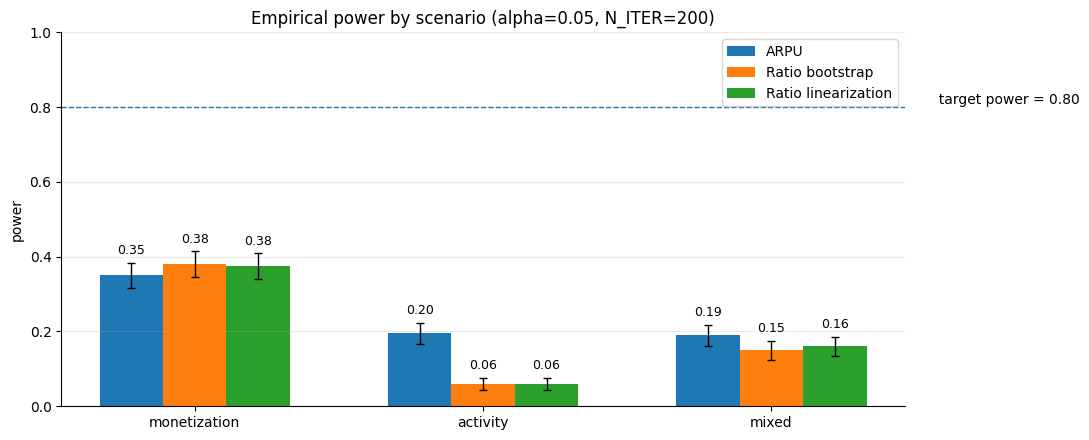

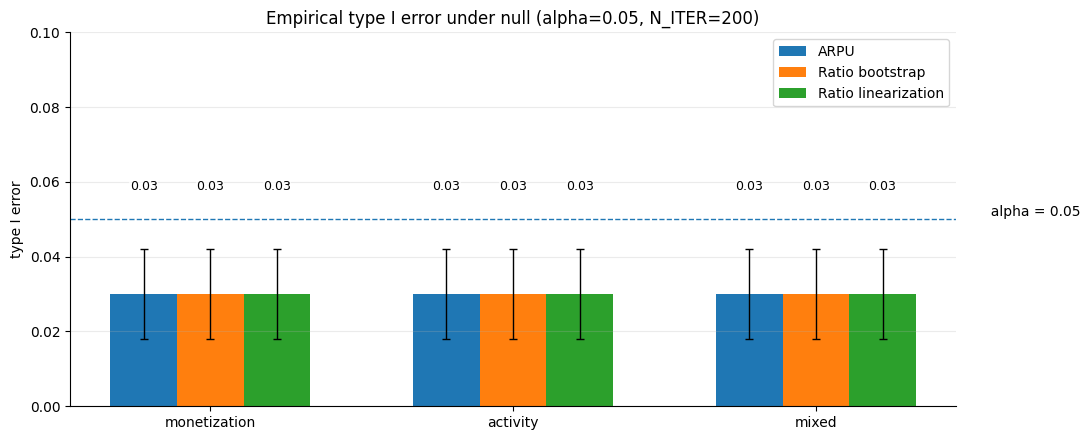

In [12]:
plot_grouped_bars(
    summary,
    value_col="power",
    se_col="power_se",
    title=f"Empirical power by scenario (alpha={ALPHA}, N_ITER={N_ITER})",
    ylabel="power",
    scenario_order=SCENARIO_ORDER,
    method_order=METHOD_ORDER,
    ref_line=0.80,
    ref_label="target power = 0.80",
    ylim=(0, 1),
)

plot_grouped_bars(
    summary,
    value_col="type1_error",
    se_col="type1_se",
    title=f"Empirical type I error under null (alpha={ALPHA}, N_ITER={N_ITER})",
    ylabel="type I error",
    scenario_order=SCENARIO_ORDER,
    method_order=METHOD_ORDER,
    ref_line=ALPHA,
    ref_label=f"alpha = {ALPHA:.2f}",
    ylim=(0, 0.10),
)

## Interpretation

- In the monetization scenario, ratio-based approaches show higher empirical power than raw ARPU because the effect lives in revenue-per-session, which ratio metrics target directly.

- In the activity scenario, ratio metrics have low power by design: increasing the number of sessions should not change revenue-per-session materially, while ARPU grows as total revenue increases.

- Under the null, all methods look conservative in this simulation (empirical type I error below 0.05). With heavy-tailed data and bootstrap-based procedures this is common at modest Monte Carlo budgets; increasing the number of null iterations makes the type I estimate more stable.

## Results summary
- Different effect mechanisms favor different primary metrics.
- Ratio metric with linearization is often more aligned with monetization-only effects.
- Bootstrap ratio test is robust but more computationally expensive.
- Under the null, type I error should be close to alpha.